In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_dataset.csv to test_dataset.csv
Saving train_dataset.csv to train_dataset.csv


In [ ]:
import pandas as pd
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

In [ ]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (984, 2)
Test shape: (424, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Bidirectional, LSTM, Dense, Dropout,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Input
)
import time

In [ ]:
train_texts = train_df['text'].astype(str).tolist()
test_texts = test_df['text'].astype(str).tolist()

train_labels = train_df['label'].values
test_labels = test_df['label'].values

In [ ]:
vocab_size = 20000
max_length = 100
tokenizer = tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

In [ ]:
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

import numpy as np

embedding_dim = 100  # ✅ Use 100D
embedding_index = {}

# Load the GloVe vectors
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Prepare embedding matrix
vocab_size = 20000  # or whatever you're using
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

--2025-05-23 00:33:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-23 00:33:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-23 00:33:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def build_bilstm():
  inputs= tf.keras.Input(shape=(max_length,))
  x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(inputs)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = GlobalAveragePooling1D()(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model = build_bilstm()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
model.fit(X_train, train_labels, validation_split=0.1, epochs=10, batch_size=32, callbacks=[early_stop])
print("\nTraining time :", round(time.time() - start_time, 2), "seconds")

model.save("bilstmmodel.h5")

model.evaluate(X_train, train_labels)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5662 - loss: 0.6790 - val_accuracy: 0.6263 - val_loss: 0.5870
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7391 - loss: 0.5273 - val_accuracy: 0.9192 - val_loss: 0.2764
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9097 - loss: 0.2217 - val_accuracy: 0.9192 - val_loss: 0.1778
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9677 - loss: 0.1318 - val_accuracy: 0.9596 - val_loss: 0.0901
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9787 - loss: 0.0943 - val_accuracy: 0.9596 - val_loss: 0.0972
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9609 - loss: 0.1148 - val_accuracy: 0.9697 - val_loss: 0.0758
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9830 - loss: 0.0523 - val_accuracy: 0.9697 - val_loss: 0.0782
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9859 - loss: 0.0521 - val_accuracy: 0.9697 - v


Training time : 12.13 seconds
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9810 - loss: 0.0566


[0.057071879506111145, 0.982723593711853]

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 64)        │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,102,341 (8.02 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 68,228 (266.52 KB)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Get predictions
y_pred_probs = model(X_test, training=False)
y_pred = (y_pred_probs.numpy() > 0.5).astype("int32").flatten()

# Evaluation
acc = accuracy_score(test_labels, y_pred)
print(f"✅ Accuracy: {acc:.4f}")

print("\n📊 Classification Report:")
print(classification_report(test_labels, y_pred))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

✅ Accuracy: 0.9741

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       170
           1       0.99      0.97      0.98       254

    accuracy                           0.97       424
   macro avg       0.97      0.98      0.97       424
weighted avg       0.97      0.97      0.97       424


🧩 Confusion Matrix:
[[167   3]
 [  8 246]]


🔹 ROC AUC Score: 0.9969
🔹 PR AUC Score: 0.9981


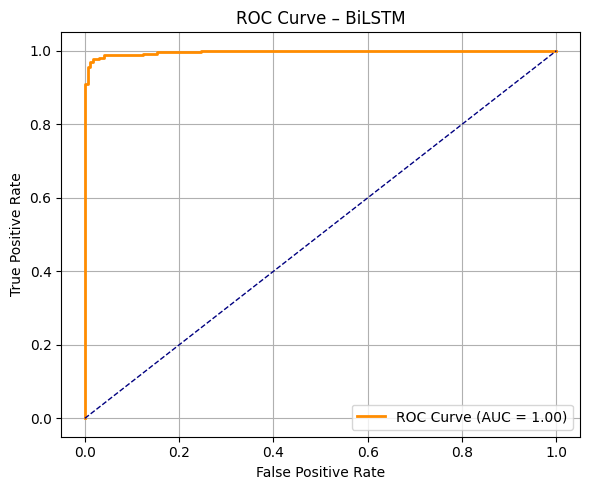

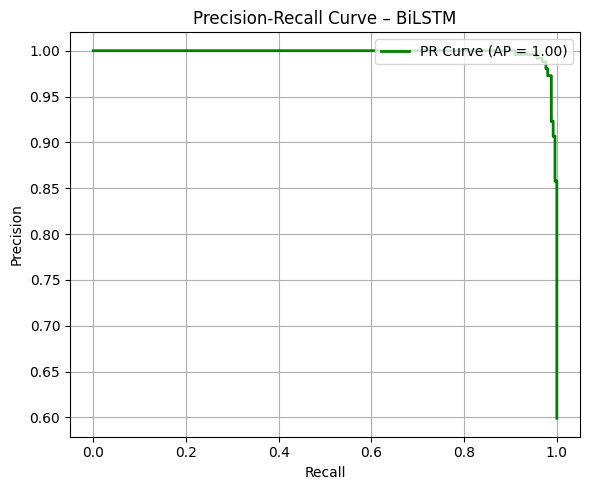

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_scores = y_pred_probs.numpy().flatten()

# ROC AUC
roc_auc = roc_auc_score(test_labels, y_scores)
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")

# PR AUC
pr_auc = average_precision_score(test_labels, y_scores)
print(f"🔹 PR AUC Score: {pr_auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – BiLSTM')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – BiLSTM')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()